# Programming Assignment 4

Celio Bueri, Christoph Stelz

## Exercise question

In the second example, the data are not linearly separable.

## Boilerplate code

In [160]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])


## SVC Implementation

In [165]:
class SVCImpl(LinearClassifier):
    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # pick random indexes for each iteration
        indices = np.random.randint(X.shape[0], size=self.n_iter)

        # initialise the number of iteration
        t = 0

        for i in indices:
            t += 1
            # update the learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = x.dot(self.w)

            # update the weights
            if y * score < 1:
                self.w = (1 - self.regularizer * lr) * self.w + lr * y * x
            else:
                self.w = (1 - self.regularizer * lr) * self.w

            # print every 100 iterations
            if self.print_epoch_stats and t % 100 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

## Logistic Regression Implementation

In [176]:
class LogisticRegressionImpl(LinearClassifier):
    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

       # pick random indexes for each iteration
        indices = np.random.randint(X.shape[0], size=self.n_iter)

        # initialise the number of iteration
        t = 0

        for i in indices:
            t += 1
            # update the learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = x.dot(self.w)

            # update the weights
            if y * score < 1:
                self.w = (1 - self.regularizer * lr) * self.w + lr * x * y / (1 + np.exp(y*score))
            else:
                self.w = (1 - self.regularizer * lr) * self.w

            # print every 100 iterations
            if self.print_epoch_stats and t % 100 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for logistic regression
            loss += np.log(1 + np.exp(-y * x.dot(self.w)))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

## Preparing training data

In [177]:

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)


## Testing our classifiers 	

In [169]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImpl(n_iter=20000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 100, train_loss : 20.454155352283077
iteration : 200, train_loss : 10.431490720950851
iteration : 300, train_loss : 6.818815696479206
iteration : 400, train_loss : 4.40849791060487
iteration : 500, train_loss : 4.164731388062037
iteration : 600, train_loss : 3.7108198508133743
iteration : 700, train_loss : 2.8170523789582584
iteration : 800, train_loss : 2.303689920960192
iteration : 900, train_loss : 2.1328214538292976
iteration : 1000, train_loss : 1.906895219785747
iteration : 1100, train_loss : 1.7414459620558334
iteration : 1200, train_loss : 1.635298974446465
iteration : 1300, train_loss : 1.8574726852928007
iteration : 1400, train_loss : 1.3179279607869085
iteration : 1500, train_loss : 2.0276983399439183
iteration : 1600, train_loss : 1.2217751730785256
iteration : 1700, train_loss : 1.1787546584697646
iteration : 1800, train_loss : 1.0680671939058548
iteration : 1900, train_loss : 1.1481482256408766
iteration : 2000, train_loss : 0.9634632174545488
iteration : 2100

In [179]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    LogisticRegressionImpl(n_iter=20000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 100, train_loss : 18.346923850221152
iteration : 200, train_loss : 8.44844584187435
iteration : 300, train_loss : 4.86279527564301
iteration : 400, train_loss : 3.6352474925896194
iteration : 500, train_loss : 2.6931446324417507
iteration : 600, train_loss : 2.26152931898637
iteration : 700, train_loss : 1.9140066962530726
iteration : 800, train_loss : 2.198708082267002
iteration : 900, train_loss : 1.5500902416490088
iteration : 1000, train_loss : 1.3836073838723995
iteration : 1100, train_loss : 1.1853112669976391
iteration : 1200, train_loss : 1.0763617650094912
iteration : 1300, train_loss : 0.984622888067199
iteration : 1400, train_loss : 0.9117174227934777
iteration : 1500, train_loss : 0.9158955806064727
iteration : 1600, train_loss : 1.287333627716432
iteration : 1700, train_loss : 0.7609371246055905
iteration : 1800, train_loss : 0.8182874408301428
iteration : 1900, train_loss : 0.6992799443791388
iteration : 2000, train_loss : 0.667702762794453
iteration : 2100, t

In [173]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'classifier__n_iter': [10000, 30000, 100000],
    'classifier__regularizer': [0.01, 0.001, 0.0001, 0.00001]
}


pipeline = Pipeline(steps=[
    ("vect",TfidfVectorizer()),
    ("select", SelectKBest(k=1000)),
    ("norm", Normalizer()),
    ("classifier", SVCImpl(print_epoch_stats=False))
])

grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, return_train_score=True)

grid_search.fit(X, Y)

print("Best parameter (loss=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Yguess = grid_search.best_estimator_.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Best parameter (loss=-0.453):
{'classifier__n_iter': 100000, 'classifier__regularizer': 0.0001}
Accuracy: 0.8758.


## Optimizing Performance

### a) BLAS operations

In this version we replaced the Numpy operations with BLAS functions from scipy.
One pitfall we encountered is that with inplace operations like `daxpy`, the argument ordering matters a lot.

In [60]:
from scipy.linalg.blas import ddot, dscal, daxpy

class SVCImplBLAS(LinearClassifier):
    def __init__(self, n_iter=20, lr=0.01, regularizer=0.0, print_epoch_stats=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lr = lr
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # training algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):

                # Compute the output score for this instance.
                score = ddot(self.w, x)
                
                dscal(1 - self.regularizer * self.lr, self.w)
                if y * score < 1:
                    daxpy(x, self.w, a=(self.lr * y))
                
            if self.print_epoch_stats:
                print(f'epoch : {i}, train_loss : {self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(ddot(self.w, self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return self.regularizer / 2 * min_weight + loss / X.shape[0]

### b) Sparse Vectors

In [136]:

class SparseSVC(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        XY = list(zip(X[indices], Ye[indices]))

        t = 0
        for i in range(self.n_iter):
            t += 1

            lr = 1.0 / (self.regularizer * t)

            x, y = XY[i]

            # Compute the output score for this instance.
            score = np.dot(self.w[x.indices], x.data)

            # regularizer
            self.w *= (1 - self.regularizer * lr)
            # If there was an error, update the weights.
            if y*score <= 0:
                self.w[x.indices] += (lr * y) * x.data

            if self.print_epoch_stats and t % 1000 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')


    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2.0 * min_weight + loss / X.shape[0])

In [138]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(),
    SparseSVC(n_iter=40000, regularizer=0.00001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))


iteration : 1000, train_loss : [16.09393676]
iteration : 2000, train_loss : [7.09094877]
iteration : 3000, train_loss : [4.40177564]
iteration : 4000, train_loss : [3.26213348]
iteration : 5000, train_loss : [2.36717034]
iteration : 6000, train_loss : [1.94579162]
iteration : 7000, train_loss : [1.52642049]
iteration : 8000, train_loss : [1.29761803]
iteration : 9000, train_loss : [1.11232521]
iteration : 10000, train_loss : [0.99499786]
iteration : 11000, train_loss : [0.85978396]
iteration : 12000, train_loss : [0.77275968]
iteration : 13000, train_loss : [0.70568607]
iteration : 14000, train_loss : [0.64325771]
iteration : 15000, train_loss : [0.58329278]
iteration : 16000, train_loss : [0.54327596]
iteration : 17000, train_loss : [0.49974744]
iteration : 18000, train_loss : [0.46316966]
iteration : 19000, train_loss : [0.43181738]
iteration : 20000, train_loss : [0.41370066]
iteration : 21000, train_loss : [0.39274772]
iteration : 22000, train_loss : [0.37197366]
iteration : 23000,

### c) Faster scaling

In [157]:
def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w, a):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return a * np.dot(w[x.indices], x.data)


class SparseSVC(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_epoch_stats=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_epoch_stats = print_epoch_stats

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        # pick indices randomly
        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        # list of instances picked randomly
        XY = list(zip(X[indices], Ye[indices]))

        # initialize vector scaling
        a = 1
        #  number of iterations
        t = 0
        for i in range(self.n_iter):
            t += 1
            # update learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = XY[i]

            # Compute the output score for this instance.
            score = sparse_dense_dot(x, self.w, a)

            # If there was an error, update the weights.
            if y*score <= 0:
                add_sparse_to_dense(x, self.w, (lr * y / a))

            # update vector scaling
            # We verify that a is positive because for large number of iteration
            # a could be rounded as 0.0 and cause an error
            if (1 - self.regularizer * lr) * a > 0.0:
                a = (1 - self.regularizer * lr) * a

        self.w =  a * self.w


    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

In [159]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1,2)),
    Normalizer(),
    SparseSVC(n_iter=100000, regularizer=0.00001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 5.83 sec.
Accuracy: 0.8531.


### Performance Evaluation

In [72]:
def evaluate_pipeline(pipeline):
    pipeline.fit(Xtrain, Ytrain) # make sure its fitted
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

#### Baseline

In [70]:
%%timeit
pipeline_baseline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImpl(print_epoch_stats=False)
)
pipeline_baseline.fit(Xtrain, Ytrain)

2.52 s ± 134 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
evaluate_pipeline(pipeline_baseline)

Accuracy: 0.8363.


#### BLAS

In [74]:
%%timeit

pipeline_blas = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImplBLAS(print_epoch_stats=False)
)
pipeline_blas.fit(Xtrain, Ytrain)

2.13 s ± 94.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
evaluate_pipeline(pipeline_blas)

Accuracy: 0.8363.


### Visualization

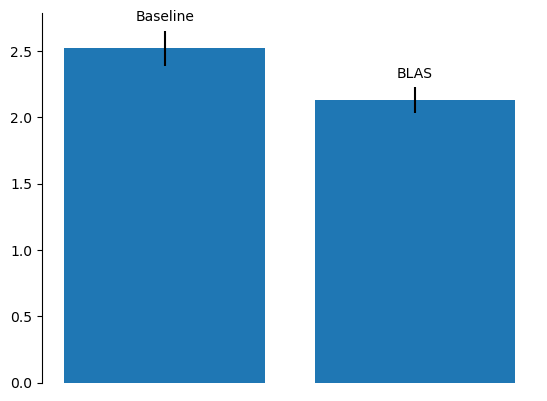

In [87]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
b = ax.bar([1,2], [2.52, 2.13], yerr=[134e-3, 94.5e-3], width=0.8)
ax.bar_label(b, labels=['Baseline', 'BLAS'], padding=5)
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.get_xaxis().set_visible(False)